# Выбор локации для скважины

Добывающей компании «ГлавРосГосНефть» нужно решить, где бурить новую скважину.

Нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализируйте возможную прибыль и риски.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

*Исходные данные по регионам:*

- d — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
- Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## 1. Загрузка и подготовка данных

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [2]:
# зададим отображение количества столбцов датафрейма
pd.options.display.max_columns = 100

# зададим формат отображения дробных чисел
pd.options.display.float_format = '{:,.2f}'.format

Загрузим данные в `reg_1`, `reg_2`, `reg_3` (по номеру региона). Выведем на экран первые 5 строк каждого датафрейма и общую информацию:

In [3]:
reg_1 = pd.read_csv('/datasets/geo_data_0.csv')
reg_2 = pd.read_csv('/datasets/geo_data_1.csv')
reg_3 = pd.read_csv('/datasets/geo_data_2.csv')

for reg in [reg_1, reg_2, reg_3]:
    print(reg.head(), '\n')

      id    f0    f1   f2  product
0  txEyH  0.71 -0.50 1.22   105.28
1  2acmU  1.33 -0.34 4.37    73.04
2  409Wp  1.02  0.15 1.42    85.27
3  iJLyR -0.03  0.14 2.98   168.62
4  Xdl7t  1.99  0.16 4.75   154.04 

      id     f0     f1    f2  product
0  kBEdx -15.00  -8.28 -0.01     3.18
1  62mP7  14.27  -3.48  1.00    26.95
2  vyE1P   6.26  -5.95  5.00   134.77
3  KcrkZ -13.08 -11.51  5.00   137.95
4  AHL4O  12.70  -8.15  5.00   134.77 

      id    f0    f1    f2  product
0  fwXo0 -1.15  0.96 -0.83    27.76
1  WJtFt  0.26  0.27 -2.53    56.07
2  ovLUW  0.19  0.29 -5.59    62.87
3  q6cA6  2.24 -0.55  0.93   114.57
4  WPMUX -0.52  1.72  5.90   149.60 



In [4]:
for reg in [reg_1, reg_2, reg_3]:
    print(reg.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
mem

Все данные - числовые. Выведем описательную статистику по каждому датафрейму:

In [5]:
print('Region 1\n', reg_1.describe().T)
print('\nRegion 2\n', reg_2.describe().T)
print('\nRegion 3\n', reg_3.describe().T)

Region 1
              count  mean   std    min   25%   50%    75%    max
f0      100,000.00  0.50  0.87  -1.41 -0.07  0.50   1.07   2.36
f1      100,000.00  0.25  0.50  -0.85 -0.20  0.25   0.70   1.34
f2      100,000.00  2.50  3.25 -12.09  0.29  2.52   4.72  16.00
product 100,000.00 92.50 44.29   0.00 56.50 91.85 128.56 185.36

Region 2
              count  mean   std    min   25%   50%    75%    max
f0      100,000.00  1.14  8.97 -31.61 -6.30  1.15   8.62  29.42
f1      100,000.00 -4.80  5.12 -26.36 -8.27 -4.81  -1.33  18.73
f2      100,000.00  2.49  1.70  -0.02  1.00  2.01   4.00   5.02
product 100,000.00 68.83 45.94   0.00 26.95 57.09 107.81 137.95

Region 3
              count  mean   std    min   25%   50%    75%    max
f0      100,000.00  0.00  1.73  -8.76 -1.16  0.01   1.16   7.24
f1      100,000.00 -0.00  1.73  -7.08 -1.17 -0.01   1.16   7.84
f2      100,000.00  2.50  3.47 -11.97  0.13  2.48   4.86  16.74
product 100,000.00 95.00 44.75   0.00 59.45 94.93 130.60 190.03


Проверим данные на наличие дубликатов:

In [6]:
for reg in [reg_1, reg_2, reg_3]:
    print('Число явных дубликатов:', reg.duplicated().sum())

Число явных дубликатов: 0
Число явных дубликатов: 0
Число явных дубликатов: 0


Проверим, не дублируются ли названия скважин в датасетах:

In [7]:
for reg in [reg_1, reg_2, reg_3]:
    print('Число дубликатов в именах скважин:', reg['id'].duplicated().sum())

Число дубликатов в именах скважин: 10
Число дубликатов в именах скважин: 4
Число дубликатов в именах скважин: 4


К сожалению, в данных о скважинах, попадаются дубликаты. Очевидно, характеристики у дублирующихся скважин - разные, так как явных дубликатов обнаружено не было. Посмотрим, что это за дубликаты: запишем дублирующиеся id в переменные `id_duplicate`:

In [8]:
id_duplicate_1 = reg_1[reg_1['id'].duplicated()]['id']
id_duplicate_2 = reg_2[reg_2['id'].duplicated()]['id']
id_duplicate_3 = reg_3[reg_3['id'].duplicated()]['id']

Выведем на экран строки с дубликатами скважин:

In [9]:
reg_1.query('id in @id_duplicate_1')

,id,f0,f1,f2,product
931,HZww2,0.76,0.37,1.86,30.68
1364,bxg6G,0.41,0.86,-3.65,73.60
1949,QcMuo,0.51,-0.32,-2.22,75.50
3389,A5aEY,-0.04,0.16,0.21,89.25
7530,HZww2,1.06,-0.37,10.43,158.83
16633,fiKDv,0.16,1.03,5.59,95.82
21426,Tdehs,0.83,0.30,-0.05,96.04
41724,bxg6G,-0.82,0.55,3.63,93.01
42529,AGS9W,1.45,-0.48,0.68,126.37
51970,A5aEY,-0.18,0.94,-2.09,33.02


In [10]:
reg_2.query('id in @id_duplicate_2')

,id,f0,f1,f2,product
1305,LHZR0,11.17,-1.95,3.00,80.86
2721,bfPNe,-9.49,-5.46,4.01,110.99
5849,5ltQ6,-3.44,-12.30,2.00,57.09
41906,LHZR0,-8.99,-4.29,2.01,57.09
47591,wt4Uk,-9.09,-8.11,-0.00,3.18
82178,bfPNe,-6.20,-4.82,3.00,84.04
82873,wt4Uk,10.26,-9.38,4.99,134.77
84461,5ltQ6,18.21,2.19,3.99,107.81


In [11]:
reg_3.query('id in @id_duplicate_3')

,id,f0,f1,f2,product
11449,VF7Jo,2.12,-0.86,5.75,181.72
28039,xCHr8,1.63,0.37,-2.38,6.12
43233,xCHr8,-0.85,2.10,5.60,184.39
44378,Vcm5J,-1.23,-2.44,1.22,137.97
45404,KUPhW,0.23,-1.70,4.99,11.72
49564,VF7Jo,-0.88,0.56,0.72,136.23
55967,KUPhW,1.21,3.18,5.54,132.83
95090,Vcm5J,2.59,1.99,2.48,92.33


Проверим линейную связь факторов. Построим матрицу корреляций и матрицу диаграмм рассеяния для каждого региона:

Матрица корреляций
            f0    f1    f2  product
f0       1.00 -0.44 -0.00     0.14
f1      -0.44  1.00  0.00    -0.19
f2      -0.00  0.00  1.00     0.48
product  0.14 -0.19  0.48     1.00 

Матрица диаграмм рассеяния



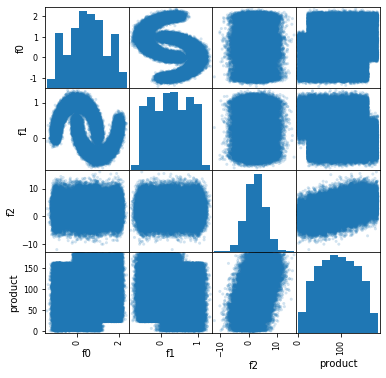

Матрица корреляций
            f0    f1    f2  product
f0       1.00  0.18 -0.00    -0.03
f1       0.18  1.00 -0.00    -0.01
f2      -0.00 -0.00  1.00     1.00
product -0.03 -0.01  1.00     1.00 

Матрица диаграмм рассеяния



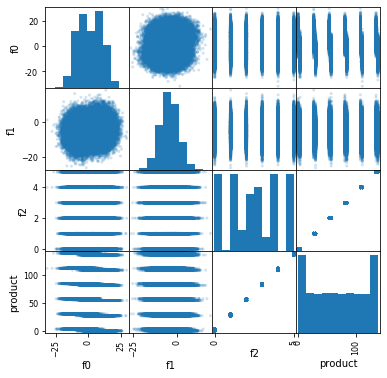

Матрица корреляций
            f0    f1    f2  product
f0       1.00  0.00 -0.00    -0.00
f1       0.00  1.00  0.00    -0.00
f2      -0.00  0.00  1.00     0.45
product -0.00 -0.00  0.45     1.00 

Матрица диаграмм рассеяния



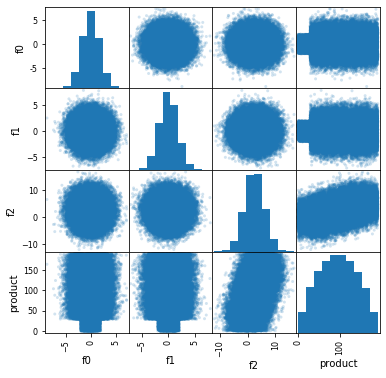

In [27]:
for reg in [reg_1, reg_2, reg_3]:
    print('Матрица корреляций\n', reg.corr(),"\n")
    print('Матрица диаграмм рассеяния\n')
    pd.plotting.scatter_matrix(reg, figsize=(6,6), alpha=0.2)
    plt.show()

**Выводы**

Датафреймы содержат по 100 тыс. записей о скважинах в каждом регионе. 

Есть небольшое количество дубликатов в названиях скважин:
- Число дубликатов в именах скважин по региону 1: 10
- Число дубликатов в именах скважин по региону 2: 4
- Число дубликатов в именах скважин по региону 3: 4

Число дубликатов крайне мало - 0.01% по первому региону и 0.004% по второму, третьему регионам. Наличие таких дубликатов никак не должно исказить исследование, поэтому их обработка не была произведена.

Отдельно отмечу, что данные в столбцах f0, f1, f2 представлены в разном масштабе. Для обучения модели регрессии необходимо будет их масштабировать.

*Характеристики линейной связи:*

Связь средней тесноты видна между f2 и product на регионах 1 и 3: коэффициент корреляции равен 0.48 и 0.45, соответственно. Связь между f2 и product в регионе 2 - прямолинейная, коэффициент корреляции = 1.00.
Факторы f0 и f1 оказывают слабое влияние на целевой признак в регионе 1 и совсем не имеют линейной связи в регионах 2 и 3.
Корреляция средней тесноты между факторами f0 и f1 наблюдается в регионе 1: коэффициент корреляции равен -0.44, зависимость обратно пропорциональная. Диаграмма рассеяния факторов f0 и f1 в регионе 1 напоминает две параболы, и скорее говорит о нелинейной зависимости.

Слабая линейная связь между факторами f0 и f1 наблюдается в регионе 2: коэффициент корреляции равен 0.18, зависимость прямо пропорциональная. Диаграмма рассеяния факторов f0 и f1 в регионе 2 имеет форму круга.
Между прочими факторами линейная связь совсем или почти отсутствует.

Диаграмма частот для объёма запасов в скважине имеет распредление, похожее на нормальное, в регионах 1 и 3. В регионе 2 есть много скважин с малым объемом запасов и много скважин с большим объемом запасов, остальные вариции не отличаются по частоте.

## 2. Обучение и проверка модели

Напишем цикл, который будет выполнять для каждого региона следующие действия:
1. Запишем в отдельные переменные признаки скважин `features` (f0, f1, f2) и целевой признак `target` (product)
2. Разделим выборку на обучающую (train) и валидационную (valid) в соотношении 75/25
3. Масштабируем признаки с помощью стандартизации StandardScaler 
4. Построим модель линейной регрессии `model`, обучим модель на `features_train`, `target_train`
5. Построим предсказания `predictions` на валидационной выборке
6. Рассчитаем и напечатаем на экране: RMSE модели, коэффициент детерминации, средний фактический запас сырья на валидационной выборке, Средний предсказанный запас сырья на валидационной выборке, первые 5 значений предсказаний на валидационной выборке.

In [95]:
reg_all = [
    reg_1.drop('id', axis=1),
    reg_2.drop('id', axis=1),
    reg_3.drop('id', axis=1),
]

s_target = []    # список значений целевой переменной на валидационной выборке
s_predictions = []   # список для прогноза целевой переменной на валидационной выборке
s_rmse = []   # список среднеквадратичных ошибок (RMSE)
s_r2 = []   # список коэффициентов детерминации (R2)
numeric = ['f0', 'f1', 'f2']    # список числовых столбцов

for regions in range(len(reg_all)):
    data = reg_all[regions]
    features = data.drop('product', axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, random_state=12345, test_size=0.25)      # разделение на обучающую и валидационную выборки
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])        # масштабирование признаков для моделирования
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    
    model = LinearRegression()    # построение модели линейной регрессии, расчет предсказаний, RMSE, R2.
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    predictions = pd.Series(predictions, index = target_valid.index)
    rmse = mean_squared_error(target_valid, predictions)**0.5
    r2 =  model.score(features_valid, target_valid)
    s_target.append(target_valid)
    s_predictions.append(predictions)
    s_rmse.append(rmse)
    s_r2.append(r2)
    print(f"\nRMSE модели линейной регрессии на валидационной выборке для региона {regions+1}:", rmse)
    print(f"Коэффициент детерминации модели линейной регрессии на валидационной выборке для региона {regions+1}:", r2)
    print(f"Средний фактический запас сырья на валидационной выборке для региона {regions+1}:", target_valid.mean())
    print(f"Средний предсказанный запас сырья на валидационной выборке для региона {regions+1}:", predictions.mean())
    print(f"Первые 5 значений предсказаний на валидационной выборке для региона {regions+1}:\n") 
    print(pd.Series(predictions).head())
    print('--------------------')


RMSE модели линейной регрессии на валидационной выборке для региона 1: 37.5794217150813
Коэффициент детерминации модели линейной регрессии на валидационной выборке для региона 1: 0.27994321524487786
Средний фактический запас сырья на валидационной выборке для региона 1: 92.07859674082927
Средний предсказанный запас сырья на валидационной выборке для региона 1: 92.59256778438038
Первые 5 значений предсказаний на валидационной выборке для региона 1:

71751   95.89
80493   77.57
2655    77.89
53233   90.18
91141   70.51
dtype: float64
--------------------

RMSE модели линейной регрессии на валидационной выборке для региона 2: 0.8930992867756158
Коэффициент детерминации модели линейной регрессии на валидационной выборке для региона 2: 0.9996233978805126
Средний фактический запас сырья на валидационной выборке для региона 2: 68.72313602435997
Средний предсказанный запас сырья на валидационной выборке для региона 2: 68.728546895446
Первые 5 значений предсказаний на валидационной выборке для

Загрузим фактические (`target_valid`) и прогнозные (`target_predict`) значения целевой переменной на валидационной выборке в отдельные переменные в соответствии с номером региона:

In [96]:
target_predict_1 = pd.Series(s_predictions[0])
target_valid_1 = pd.Series(s_target[0])
target_predict_2 = pd.Series(s_predictions[1])
target_valid_2 = pd.Series(s_target[1])
target_predict_3 = pd.Series(s_predictions[2])
target_valid_3 = pd.Series(s_target[2])

*Выводы*

Мы построили 3 модели линейной регрессии для каждого региона. Наилучшего качество удалось достичь в модели региона 2, где cреднеквадратичная ошибка (RMSE) на валидационной выборке равна 0.89. Очевидно, это следствие высокой корреляции между фактором f2 и целевой переменной.

Самый большой средний предсказанный запас сырья в регионе 3: 94.97 тыс. баррелей. Второе место по предсказанным запасам - регион 1, где запас сырья = 92.59 тыс. баррелей. на последнем месте регион 3, средний предсказанный запас сырья = 68.73 тыс. баррелей.

## 3. Подготовка к расчёту прибыли

Все ключевые значения для расчётов прибыли сохраним в отдельных переменных:

- `best_points` - число лучших скважин для разработки,
- `budget` - бюджет на разработку скважин в регионе (тыс. руб.),
- `income` - доход с одной тысячи скважин (тыс. руб.),
- `stop_loss` - достаточный объём сырья для безубыточной разработки одной новой скважины (тыс. баррелей).

In [97]:
best_points = 200
budget = 10000000
income = 450

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе.

In [98]:
stop_loss = budget/best_points/income
stop_loss

111.11111111111111

In [99]:
print("Средний запас сырья одной скважины в регионе 1:", reg_1['product'].mean())
print("Средний запас сырья одной скважины в регионе 2:", reg_2['product'].mean())
print("Средний запас сырья одной скважины в регионе 3:", reg_3['product'].mean())

Средний запас сырья одной скважины в регионе 1: 92.50000000000001
Средний запас сырья одной скважины в регионе 2: 68.82500000000002
Средний запас сырья одной скважины в регионе 3: 95.00000000000004


Средние запасы сырья в регионах 1 и 3 (92.5 и 95.0 тыс. баррелей, соответственно) ближе к значению `stop_loss`, чем средние запасы в регионе 2 (68.8 тыс. баррелей).

Напишем функцию `revenue` для расчёта прибыли по выбранным скважинам и предсказаниям модели:
1. Выберем скважины с максимальными значениями предсказаний.
2. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
3. Рассчитаем прибыль для полученного объёма сырья.

Аргументы функции `revenue`: 
- predictions - предсказанные значения запасов нефти,
- target - исходные значения запасов нефти,
- count - число скважин, которые выбираем для разработки,
- income - доход с одной тысячи баррелей.

In [100]:
def revenue(predictions, target, count, income):
    pred_sorted = predictions.sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    pred_sum = pred_sorted.sum()
    return income * selected.sum() - budget

In [101]:
revenue_1 = revenue(target_predict_1, target_valid_1, best_points, income)
revenue_2 = revenue(target_predict_2, target_valid_2, best_points, income)
revenue_3 = revenue(target_predict_3, target_valid_3, best_points, income)
print("Прибыль по региону 1:", revenue_1)
print("Прибыль по региону 2:", revenue_2)
print("Прибыль по региону 3:", revenue_3)

Прибыль по региону 1: 3320826.0431398526
Прибыль по региону 2: 2415086.6966815125
Прибыль по региону 3: 2710349.9635998327


*Вывод*

Минимальный объем сырья для безубыточной разработки одной скважины составляет 111.11 тыс. баррелей. Средние запасы сырья на одну скважину во всех трёх регионах ниже этого значения. В регионах 1 и 3 средние запасы на скважину равны 92.5 и 95.0 тыс. баррелей, соответственно (а на валидационной выборке: 92.6 и 95.0) - в этих регионах запасы ближе к значению stop_loss, чем средние запасы в регионе 2 (среднее = 68.8 тыс. баррелей и 68.7 тыс. баррелей на валидационной выборке).

С учетом запасов нефти, указанных в исходных данных, мы рассчитали максимально возможные прибыли для 3-х регионов. Наибольший объем прибыли от разработки 200 точек возможен в регионе 1: 3.3 млрд. руб. На втором месте регион 3 со значением 2.7 млрд. руб. На третьем месте регион 2 со значением 2.4 млрд. руб.

## 4. Расчёт прибыли и рисков 

Посчитаем риски и прибыль для каждого региона:
1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
2. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков (отрицательной прибыли).

Зададим параметр `state`, число выборок `bootstrap_samples`, число скважин в выборке `points`:

In [102]:
state = np.random.RandomState(12345)
bootstrap_samples = 1000
points = 500

Напишем цикл, который создаст 1000 выборок из 500 скважин, а после рассчитает прибыль по 200-скважинам с максимальными предсказанными значениями объема добычи. Значения полученных прибылей будем сохранять в список `revenue_sample`. Число выборок, сформирующих отрицательную прибыль, сохраним в переменной `sample_loss`.

Рассчитаем данные по региону 1 (в названия переменных добавим "1"):

In [103]:
revenue_sample_1 = []
sample_loss_1 = 0
for i in range(bootstrap_samples):
    target_predict_1_sample = target_predict_1.sample(n=points, random_state=state, replace=True)
    rev = revenue(target_predict_1_sample, target_valid_1, best_points, income)
    revenue_sample_1.append(rev)
    if rev < 0:
        sample_loss_1 +=1

Найдем среднюю прибыль по региону 1, 95%-й доверительный интервал и риск убытков (отрицательной прибыли):

In [104]:
risk_of_loss_1 = sample_loss_1 / bootstrap_samples
revenue_sample_1 = pd.Series(revenue_sample_1)
conf_int_min_1 = revenue_sample_1.quantile(0.025)
conf_int_max_1 = revenue_sample_1.quantile(0.975)

print('Среднее значение прибыли в регионе 1:', revenue_sample_1.mean())
print(f'95%-й доверительный интервал для средней прибыли в регионе 1: от {conf_int_min_1} до {conf_int_max_1}')
print(f'Риск убытков в регионе 1: {round(risk_of_loss_1*100, 2)}%')

Среднее значение прибыли в регионе 1: 396164.98480237107
95%-й доверительный интервал для средней прибыли в регионе 1: от -111215.54589049605 до 909766.941553422
Риск убытков в регионе 1: 6.9%


Рассчитаем данные по региону 2 (в названия переменных добавим "2"):

In [105]:
revenue_sample_2 = []
sample_loss_2 = 0
for i in range(bootstrap_samples):
    target_predict_2_sample = target_predict_2.sample(n=points, random_state=state, replace=True)
    rev = revenue(target_predict_2_sample, target_valid_2, best_points, income)
    revenue_sample_2.append(rev)
    if rev < 0:
        sample_loss_2 +=1

Найдем среднюю прибыль по региону 2, 95%-й доверительный интервал и риск убытков (отрицательной прибыли):

In [106]:
risk_of_loss_2 = sample_loss_2 / bootstrap_samples
revenue_sample_2 = pd.Series(revenue_sample_2)
conf_int_min_2 = revenue_sample_2.quantile(0.025)
conf_int_max_2 = revenue_sample_2.quantile(0.975)

print('Среднее значение прибыли в регионе 2:', revenue_sample_2.mean())
print(f'95%-й доверительный интервал для средней прибыли в регионе 2: от {conf_int_min_2} до {conf_int_max_2}')
print(f'Риск убытков в регионе 2: {round(risk_of_loss_2*100, 2)}%')

Среднее значение прибыли в регионе 2: 461155.8172772397
95%-й доверительный интервал для средней прибыли в регионе 2: от 78050.81075174107 до 862952.0602637231
Риск убытков в регионе 2: 0.7%


Рассчитаем данные по региону 3 (в названия переменных добавим "3"):

In [107]:
revenue_sample_3 = []
sample_loss_3 = 0
for i in range(bootstrap_samples):
    target_predict_3_sample = target_predict_3.sample(n=points, random_state=state, replace=True)
    rev = revenue(target_predict_3_sample, target_valid_3, best_points, income)
    revenue_sample_3.append(rev)
    if rev < 0:
        sample_loss_3 +=1

Найдем среднюю прибыль по региону 3, 95%-й доверительный интервал и риск убытков (отрицательной прибыли):

In [108]:
risk_of_loss_3 = sample_loss_3 / bootstrap_samples
revenue_sample_3 = pd.Series(revenue_sample_3)
conf_int_min_3 = revenue_sample_3.quantile(0.025)
conf_int_max_3 = revenue_sample_3.quantile(0.975)

print('Среднее значение прибыли в регионе 3:', revenue_sample_3.mean())
print(f'95%-й доверительный интервал для средней прибыли в регионе 3: от {conf_int_min_3} до {conf_int_max_3}')
print(f'Риск убытков в регионе 3: {round(risk_of_loss_3*100, 2)}%')

Среднее значение прибыли в регионе 3: 392950.4751706045
95%-й доверительный интервал для средней прибыли в регионе 3: от -112227.62537857569 до 934562.914551164
Риск убытков в регионе 3: 6.5%


Соберем полученные данные в датафрейм `aggregation` для наглядности полученных результатов:

In [109]:
aggregation = pd.DataFrame({'revenue_mean': [revenue_sample_1.mean(), revenue_sample_2.mean(), revenue_sample_3.mean()],
                        'confidence_interval (min)': [conf_int_min_1, conf_int_min_2, conf_int_min_3],
                        'confidence_interval (max)': [conf_int_max_1, conf_int_max_2, conf_int_max_3],
                        'risk_of_loss (%)': [risk_of_loss_1*100, risk_of_loss_2*100, risk_of_loss_3*100],
                         'RMSE': s_rmse,
                         'R2': s_r2}, 
            index= ['region_1', 'region_2', 'region_3'])
aggregation

,revenue_mean,confidence_interval (min),confidence_interval (max),risk_of_loss (%),RMSE,R2
region_1,"396,164.98","-111,215.55","909,766.94",6.90,37.58,0.28
region_2,"461,155.82","78,050.81","862,952.06",0.70,0.89,1.00
region_3,"392,950.48","-112,227.63","934,562.91",6.50,40.03,0.21


*Выводы*

Таким образом, регионы 1 и 3 показали похожие значения средней прибыли и риска убытков. 

**Наиболее перспективным регионом с точки зрения инвестиций является регион 2:**
- среднее значение прибыли (461.2 млн. руб.) на 16% лучше региона 1 и на 17% лучше региона 3, 
- 95%-доверительный интервал: от 78 млн до 863 млн. Доверительный интервал начинается с положительного значения, в отличие от прочих регионов,
- риск убытков самый низкий: 0.7% против 6.9% и 6,5% в регионах 1 и 3, соответственно,
- качество построенной модели для региона 2 наилучшее, относительно прочих регионов: cреднеквадратичная ошибка равна 0.89, коэффициент детерминации = 1.0.

## 5. Общий вывод

В ходе исследования были изучены данные о запасах нефти в 3-х регионах: в каждом по 100 000 скважин.
Исходные характеристики месторождений были масштабированы для построения 3-х моделей линейной регрессии. Наилучшее качество показала модель 2-го региона. Качество построенных моделей:
1. Регион 1: cреднеквадратичная ошибка = 37.58, коэф. детерминации = 0.28
2. Регион 2: cреднеквадратичная ошибка = 0.89, коэф. детерминации = 1.00
3. Регион 3: cреднеквадратичная ошибка = 40.03, коэф. детерминации = 0.21

Также в ходе работы был определен минимальный объем сырья, необходимый для безубыточной разработки одной скважины: 111.111 тыс. баррелей. 
Средние запасы сырья на одну скважину во всех трёх регионах ниже этого значения. В регионах 1 и 3 средние запасы на скважину равны 92.5 и 95.0 тыс. баррелей, соответственно (а на валидационной выборке: 92.6 и 95.0) - в этих регионах запасы ближе к значению безубыточности, чем средние запасы в регионе 2 (среднее = 68.8 тыс. баррелей и 68.7 тыс. баррелей на валидационной выборке).

С учетом запасов нефти, указанных в исходных данных, были рассчитаны максимально возможные прибыли для 3-х регионов на валидационных данных:

- Наибольший объем прибыли от разработки 200 точек возможен в регионе 1: 3.3 млрд. руб. 
- На втором месте регион 3 со значением 2.7 млрд. руб. 
- На третьем месте регион 2 со значением 2.4 млрд. руб.

Однако, у компании нет возможности для исследования всех скважин в регионе. При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки. 
При выборе 500 случайных скважин на валидационных данных и отборе ТОП-200 среди них, были сделаны прогнозы средней прибыли, произведен расчет 95%-доверительного интервала для средней прибыли и оценены риски убытков (отрицательной прибыли).

**Наиболее перспективный регион для разработки: регион 2**
- среднее значение прибыли равно 461.2 млн. руб. - это на 16% лучше региона 1 и на 17% лучше региона 3, 
- 95%-доверительный интервал для средней прибыли: от 78 млн до 863 млн. Доверительный интервал начинается с положительного значения, в отличие от прочих регионов,
- риск убытков самый низкий: 0.7% против 6.9% и 6,5% в регионах 1 и 3, соответственно,
- качество построенной модели для региона 2 наилучшее, относительно прочих регионов: RMSE = 0.89, R2 = 1.0. Значит, полученные результаты являются наиболее надежными